# Complete architecture

## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
from IPython.display import HTML


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /

In [4]:
if platform.system() == "Darwin":
    root_directory_work = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    root_directory_work = '/content/drive/MyDrive/Progetto_gait_recognition'

print('root directory is ' + root_directory)

root directory is /content


## Classifier

### Train - Test Split


In [5]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory_work +'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)
reference_df['Subject'] = reference_df['Name_file'].str[:5].str.replace('_', '')

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Subject
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9
...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8


In [6]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)                       # imposta Complete_path come indice per la mia tabella
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label,Subject
Complete_path,,,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0,Sbj9
...,...,...,...,...,...
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2,Sbj8


In [7]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])


# We want to split the data using 10 subjects for training, 1 subject for validation and 1 subject for test
# In this way we are sure that train and test are completely dinstinct

# train_val_test split
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
test_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
test_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]

#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts(), '\n')
print("Test Skelly")
print(test_s['Label'].value_counts(), '\n', '\n')
print("Train Pressure")
print(train_p['Label'].value_counts(), '\n')
print("Test Pressure")
print(test_p['Label'].value_counts())

print(len(train_p))

train_p

Train Skelly
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Skelly
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64 
 

Train Pressure
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Pressure
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64
1320


,Name_file,Label,Subject
Complete_path,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial4/Sbj9_antalgic_T4_P.csv,Sbj9_antalgic_T4_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial7/Sbj9_antalgic_T7_P.csv,Sbj9_antalgic_T7_P.csv,0,Sbj9
...,...,...,...
/content/dataset/subject8/normal/trial20/Sbj8_normal_T20_P.csv,Sbj8_normal_T20_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial19/Sbj8_normal_T19_P.csv,Sbj8_normal_T19_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_P.csv,Sbj8_normal_T17_P.csv,2,Sbj8


### Skeleton processing

In [8]:
# def len_data_sk(complete_path, load=True):

#     if load:
#         complete_path = complete_path.decode()

#     df_skelly = pd.read_csv(complete_path, header=None)
#     df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

#     #convert to np array and reshape
#     data = df_skelly.to_numpy().reshape((-1,32,3))
#     l = data.shape[0]

#     return np.float32(l)


# def create_dataset_sk(table, cache_file, shuffle, batch_size, target_size=75, noise_time=20, center_crop=False, flip=False, repeat=True):

#   # shape
#   input_size = (target_size, 32, 3)

#   # Convert dataframe to lists
#   file_names = list(table.index)
#   labels = table['Label']

#   # Create a Dataset object
#   dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
#   # Now, 'dataset' contains tuples of 'file_names' and 'labels', where each tuple represents a single example

#   # Map the load_and_preprocess_data function
#   py_func = lambda path, label: (tf.numpy_function(len_data_sk, [path], tf.float32), label)
#   dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

#   # Cache dataset
#   if cache_file:
#       dataset = dataset.cache(cache_file)

#   # Shuffle
#   if shuffle:
#       dataset = dataset.shuffle(len(file_names))

#   # Repeat the dataset indefinitely
#   if repeat:
#     dataset = dataset.repeat()

#   # Batch
#   dataset = dataset.batch(batch_size=batch_size)

#   # Prefetch
#   dataset = dataset.prefetch(buffer_size=1)

#   return dataset

# batch_s = 3000

# dataset_train_s = create_dataset_sk(table = train_s,
#                                     cache_file = False,
#                                     shuffle = False,
#                                     batch_size = batch_s,
#                                     target_size = 75,
#                                     noise_time = 20,
#                                     center_crop = False,
#                                     flip = False,
#                                     repeat=False)

# train_steps_s = int(np.ceil(len(train_s)/batch_s))

# first_element_dataset_k = dataset_train_s.take(1)
# first_element_dataset_k

# for d, l in first_element_dataset_k:
#   print(d.numpy().shape, l.numpy().shape)

# plt.hist(d.numpy(), bins=30, edgecolor='black')

# # Impostare le etichette degli assi e il titolo
# plt.xlabel('Valore')
# plt.ylabel('Frequenza')
# plt.title('Istogramma dei valori')

# # Mostrare l'istogramma
# plt.show()

/content/dataset/subject1/normal/trial9/Sbj1_normal_T9_S.csv
Original shape  (118, 32, 3)


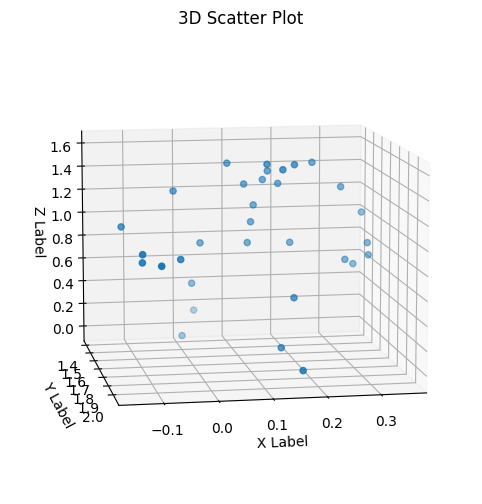

In [9]:
def load_data_sk(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    #convert to np array and reshape
    data = df_skelly.to_numpy().reshape((-1,32,3))

    # return data.shape[0]
    return data.squeeze()


# Example
index = train_s.index[756]
sk_data = load_data_sk(index, load=False)
sk_data
print(index)
print('Original shape ', sk_data.shape)

plotdata = sk_data[100]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()

# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data), fargs=(sk_data,), blit=False)

# # Display the animation
# load_sk = HTML(ani.to_jshtml())


In [10]:
# load_sk

In [11]:
joint_dataframe = {'SPINE' : ['0 - PELVIS', '1 - SPINE_NAVAL', '2 - SPINE_CHEST', '3 - NECK', '', '', ''],
                   'LEFT ARM': ['4 - CLAVICLE_LEFT', '5 - SHOULDER_LEFT', '6 - ELBOW_LEFT', '7 - WRIST_LEFT', '8 - HAND_LEFT', '9 - HANDTIP_LEFT', '10 - THUMB_LEFT'],
                   'RIGHT ARM': ['11 - CLAVICLE_RIGHT', '12 - SHOULDER_RIGHT', '13 - ELBOW_RIGHT', '14 - WRIST_RIGHT', '15 - HAND_RIGHT', '16 - HANDTIP_RIGHT', '17 - THUMB_RIGHT'],
                   'LEFT LEG': ['18 - HIP_LEFT', '19 - KNEE_LEFT', '20 - ANKLE_LEFT', '21 - FOOT_LEFT', '', '', ''],
                   'RIGHT LEG': ['22 - HIP_RIGHT', '23 - KNEE_RIGHT', '24 - ANKLE_RIGHT', '25 - FOOT_RIGHT', '', '', ''],
                   'HEAD': ['26 - HEAD', '27 - NOSE', '28 - EYE_LEFT', '29 - EAR_LEFT', '30 - EYE_RIGHT', '31 - EAR_RIGHT', '']}

joint_df = pd.DataFrame(joint_dataframe)
joint_df

,SPINE,LEFT ARM,RIGHT ARM,LEFT LEG,RIGHT LEG,HEAD
0,0 - PELVIS,4 - CLAVICLE_LEFT,11 - CLAVICLE_RIGHT,18 - HIP_LEFT,22 - HIP_RIGHT,26 - HEAD
1,1 - SPINE_NAVAL,5 - SHOULDER_LEFT,12 - SHOULDER_RIGHT,19 - KNEE_LEFT,23 - KNEE_RIGHT,27 - NOSE
2,2 - SPINE_CHEST,6 - ELBOW_LEFT,13 - ELBOW_RIGHT,20 - ANKLE_LEFT,24 - ANKLE_RIGHT,28 - EYE_LEFT
3,3 - NECK,7 - WRIST_LEFT,14 - WRIST_RIGHT,21 - FOOT_LEFT,25 - FOOT_RIGHT,29 - EAR_LEFT
4,,8 - HAND_LEFT,15 - HAND_RIGHT,,,30 - EYE_RIGHT
5,,9 - HANDTIP_LEFT,16 - HANDTIP_RIGHT,,,31 - EAR_RIGHT
6,,10 - THUMB_LEFT,17 - THUMB_RIGHT,,,


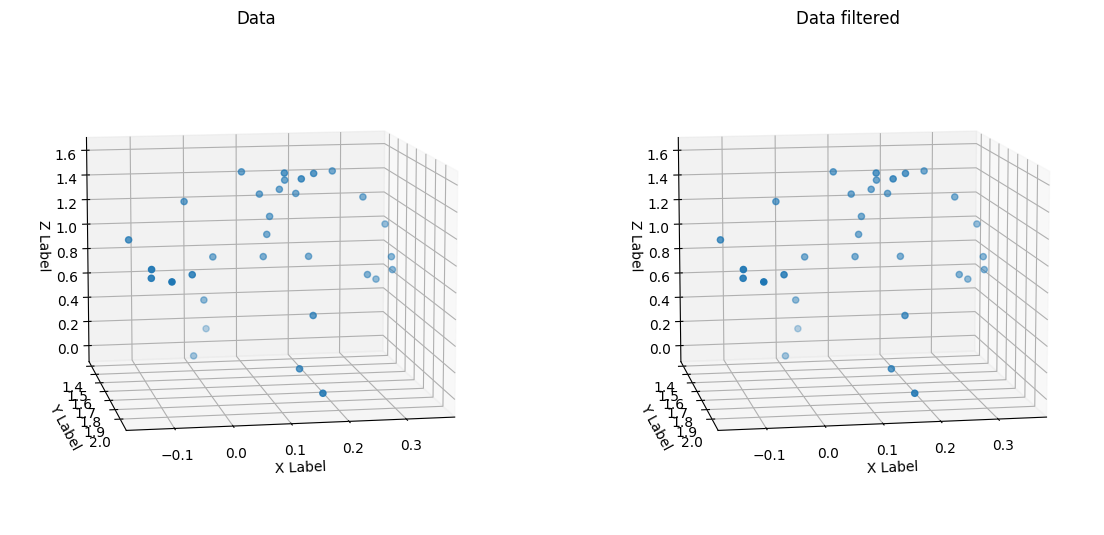

In [12]:
def remove_joints(data, joint_list = [], load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass
        # print('no filtering')

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly


# Example
index = train_s.index[756]
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, [], load=False)

plotdata = sk_data[100]
plotdata_fil = sk_data_filter[100]

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('Data')
ax1.view_init(elev=10, azim=80)
ax1.invert_xaxis()

ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(plotdata_fil[:, 0], plotdata_fil[:, 1], plotdata_fil[:, 2])
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('Data filtered')
ax2.view_init(elev=10, azim=80)
ax2.invert_xaxis()

plt.show()

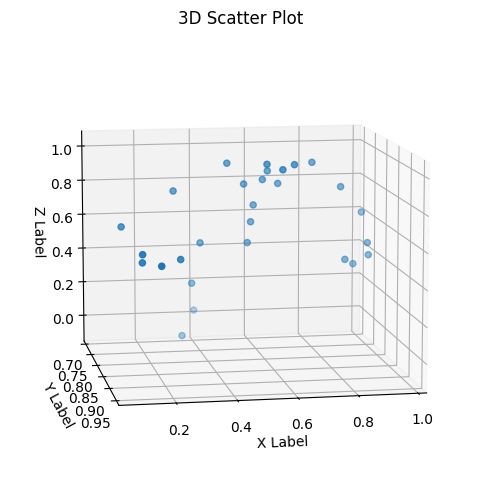

In [13]:
def normalize_data_sk(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


# Example
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, ['rleg'], load=False)
sk_data_norm = normalize_data_sk(sk_data_filter)


#plot example, select only one frame
plotdata = sk_data_norm[100]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()


# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_norm), fargs=(sk_data_norm,), blit=False)

# # Display the animation
# norm_sk = HTML(ani.to_jshtml())

In [14]:
# norm_sk

Original shape  (118, 32, 3) Cropped/Padded shape  (50, 28, 3)


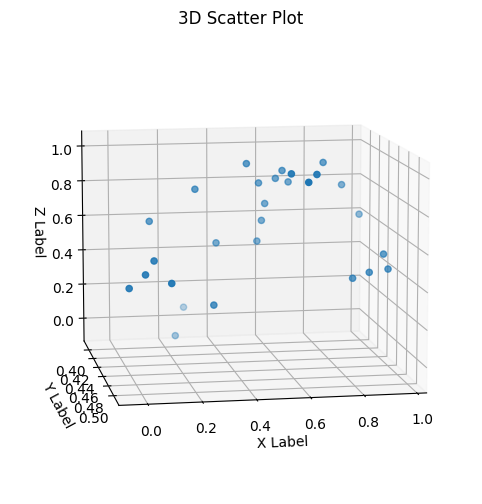

In [15]:
def random_crop(data, target_size=50, center_crop=False):

  noise_time_begin = int(data.shape[0]/2) - 10
  noise_time_end = 5

  # remove initial and final frames that we consider as noise
  start = noise_time_begin
  end = data.shape[0] - noise_time_end

  data = data[start:end, :]

  N = data.shape[0]

  # Random Crop (always centered if center_crop=True)
  if center_crop:
      from_ = int((N / 2) - (target_size / 2))
      # print('Start of the crop: ', from_)
  else:
      from_ = np.random.randint(0, np.floor(N - target_size))
      # print('Start of the crop: ', from_)

  return data[from_:from_ + target_size]


# Example
sk_data = load_data_sk(index, load=False)
sk_data_filter = remove_joints(sk_data, ['rleg'], load=False)
sk_data_norm = normalize_data_sk(sk_data_filter)

sk_data_crop = random_crop(sk_data_norm)
print('Original shape ', sk_data.shape, 'Cropped/Padded shape ', sk_data_crop.shape)

plotdata = sk_data_crop[20]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
ax.invert_xaxis()
plt.show()


# # Create a function to update the plot
# def update(frame, data):
#     ax.cla()
#     sc = ax.scatter(data[frame,:, 0], data[frame,:, 1], data[frame,:, 2])
#     ax.invert_xaxis()
#     return sc

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(sk_data_crop), fargs=(sk_data_crop,), blit=False)

# # Display the animation
# crop_sk = HTML(ani.to_jshtml())

In [16]:
# crop_sk

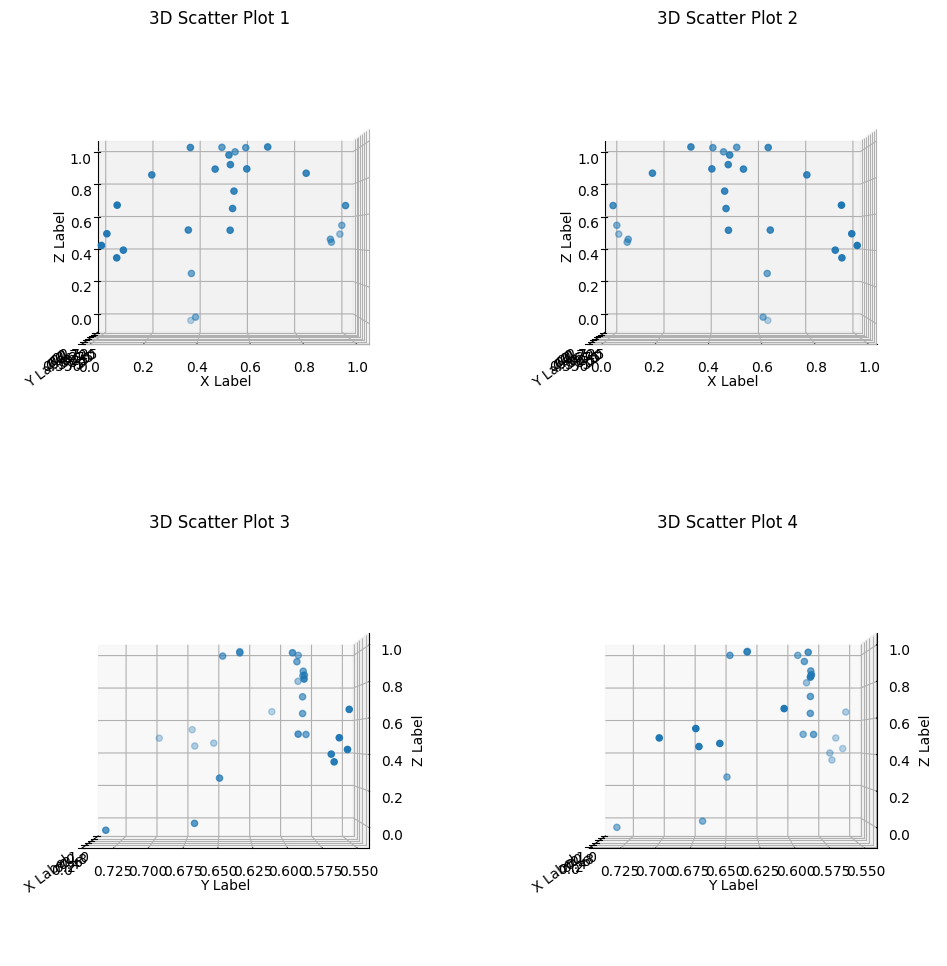

In [17]:
def random_flip(data, prob_flip=0.5):

    x_data = data[:, :, 0]
    y_data = data[:, :, 1]
    z_data = data[:, :, 2]

    p = np.random.rand()

    if p < prob_flip:
        # print('Inversione avvenuta')
        x_data = 1 - x_data



    data_flip = np.dstack((x_data, y_data, z_data))

    return data_flip


# Example
sk_data_flip = random_flip(sk_data_crop, prob_flip=1)

frame = 30
plotdata = sk_data_crop[frame]
plotdata_f = sk_data_flip[frame]


fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax1.set_xlabel('X Label')
ax1.set_ylabel('Y Label')
ax1.set_zlabel('Z Label')
ax1.set_title('3D Scatter Plot 1')
ax1.view_init(elev=0, azim=-90)

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(plotdata_f[:, 0], plotdata_f[:, 1], plotdata_f[:, 2])
ax2.set_xlabel('X Label')
ax2.set_ylabel('Y Label')
ax2.set_zlabel('Z Label')
ax2.set_title('3D Scatter Plot 2')
ax2.view_init(elev=0, azim=-90)

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax3.set_xlabel('X Label')
ax3.set_ylabel('Y Label')
ax3.set_zlabel('Z Label')
ax3.set_title('3D Scatter Plot 3')
ax3.view_init(elev=0, azim=-180)

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(plotdata_f[:, 0], plotdata_f[:, 1], plotdata_f[:, 2])
ax4.set_xlabel('X Label')
ax4.set_ylabel('Y Label')
ax4.set_zlabel('Z Label')
ax4.set_title('3D Scatter Plot 4')
ax4.view_init(elev=0, azim=-180)

plt.show()

In [18]:
def load_prep_sk(complete_path, joints, load = True):
    data = load_data_sk(complete_path, load)
    data = normalize_data_sk(data)
    data = remove_joints(data, joints)

    return data.astype(np.float32)


### Pressure processing

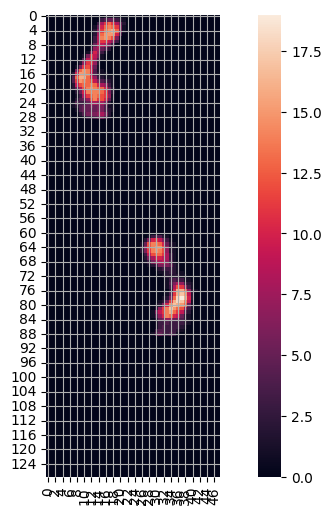

In [19]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()


# Example
ps_data = load_data_ps(train_p.index[330], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

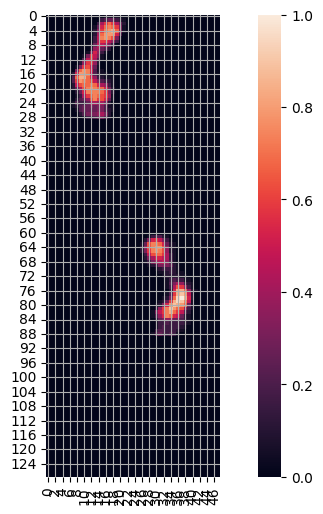

In [20]:
def normalize_data_ps(data):
    massimo = np.max(data)
    data = data / massimo
    return data

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)

sns.heatmap(ps_data_norm, square= True)
plt.show()

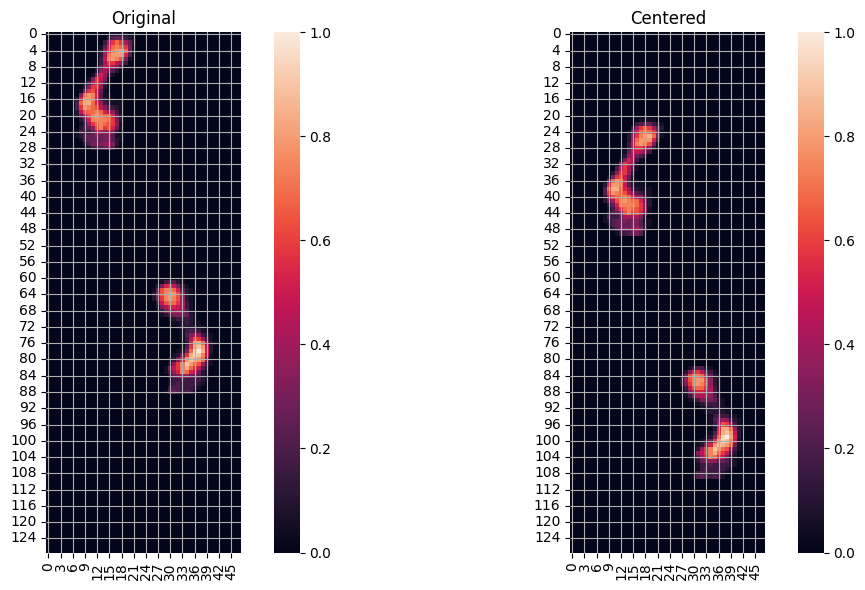

In [21]:
def baricenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
  # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_matrix = np.roll(data, int(shift_x), axis=1)
  shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

  # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
  # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
  # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

  return shifted_matrix

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)
cen_ps_data_norm = baricenter(ps_data_norm)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Centered')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

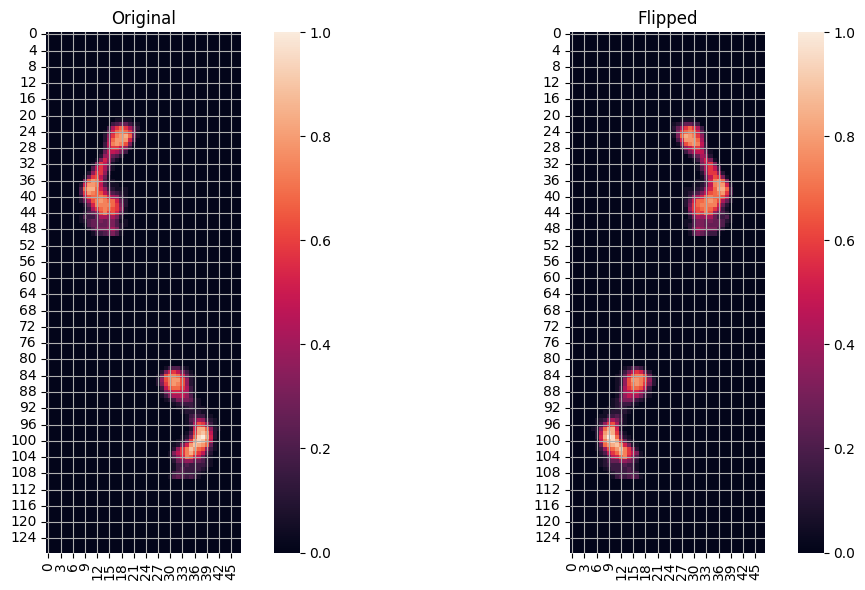

In [22]:
def augment_data(data, flip_rate=0.5):
    a = np.random.rand()

    if a < flip_rate:
        #print("Flip data")
        data = np.flip(data, axis=1)
    return data

cen_ps_data_norm_flip = augment_data(cen_ps_data_norm, flip_rate=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(cen_ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm_flip, square=True,ax=axes[1])
axes[1].set_title('Flipped')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
def load_prep_ps(complete_path):
    data = load_data_ps(complete_path, load=True)
    data = normalize_data_ps(data)
    data = baricenter(data)

    return data.astype(np.float32)

### Dataset skeletron

In [24]:
def create_dataset_sk(table, cache_file, shuffle, batch_size, num_sbj, remove_joints=[], target_size=50, center_crop=False, train=False, validation=False, test=False, flip_rate=0.5, repeat=True):

  input_size = (target_size, 12, 3)

  subject_0 = 'Sbj' + str(num_sbj)
  # subject_1 = 'Sbj' + str(num_sbj+1)

  if num_sbj == 0:
      new_table = table

  else:
      if train:
        new_table = table[table['Subject'] != subject_0]
        # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

      elif validation:
        new_table = table[table['Subject'] == subject_0]
        # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

      elif test:
        new_table = table

      else:
        print("Error, select train, validation or test setting")
        return None

  # print(new_table)

  # Convert dataframe to lists
  file_names = list(new_table.index)
  labels = new_table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_sk, [path, remove_joints], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Repeat the dataset indefinitely
  if repeat:
    dataset = dataset.repeat()

  # Map the crop function
  py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop, [data, target_size, center_crop], tf.float32), input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Map the flip function
  if flip_rate:
      py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_flip, [data], tf.float32), input_size), label)
      dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())


  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

In [25]:
# batch_sk = 30

# sbj = 1
# train_name_file = 'train_s_00' + str(sbj)

# dataset_train_sk = create_dataset_sk(table = train_s,
#                                      remove_joints = ['rarm'],
#                                      cache_file = train_name_file,
#                                      shuffle = True,
#                                      batch_size = batch_sk,
#                                      num_sbj = sbj,
#                                      train = True)



# train_steps_sk = int(np.ceil(1200/batch_sk))

# first_element_dataset_sk = dataset_train_sk.take(1)
# first_element_dataset_sk

# for d, l in first_element_dataset_sk:
#   print(d.numpy().shape, l.numpy().shape)

# num_joints = d.numpy().shape[2]

### Dataset pressure

In [26]:
def create_dataset_ps(table, cache_file, shuffle, batch_size, num_sbj, train=False, validation=False, test=False, flip_rate=0.5, repeat=True):

  input_size = (128, 48, 1)

  subject_0 = 'Sbj' + str(num_sbj)
  # subject_1 = 'Sbj' + str(num_sbj+1)

  if num_sbj == 0:
      new_table = table

  else:
      if train:
        new_table = table[table['Subject'] != subject_0]
        # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

      elif validation:
        new_table = table[table['Subject'] == subject_0]
        # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

      elif test:
        new_table = table

      else:
        print("Error, select train, validation or test setting")
        return None

  # print(new_table)

  # Convert dataframe to lists
  file_names = list(new_table.index)
  labels = new_table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the flip function
  if flip_rate:
        py_func = lambda path,label: (tf.numpy_function(augment_data, [path], tf.float32),label)
        dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Repeat the dataset indefinitely
  if repeat:
    dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 2), label))

  py_func = lambda img, label: (tf.ensure_shape(img, input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

In [27]:
# batch_p = 60

# sbj = 1
# train_name_file = 'train_p_00' + str(sbj)

# dataset_train_p = create_dataset_ps(table = train_p,
#                                     cache_file = train_name_file,
#                                     shuffle = True,
#                                     batch_size = batch_p,
#                                     num_sbj = sbj,
#                                     train = True)



# train_steps_p = int(np.ceil(1200/batch_p))
# val_steps_p = int(np.ceil(120/batch_p))


# first_element_dataset_p = dataset_train_p.take(1)
# first_element_dataset_p

# for d, l in first_element_dataset_p:
#   print(d.numpy().shape, l.numpy().shape)

## Joint dataset

### Train - Test Split


In [28]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv('/content/drive/MyDrive/Progetto_gait_recognition/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)

def process_string(r):
    compl_type = r[:-6]
    return compl_type

reference_df['Complete_type'] = reference_df.apply(lambda row: process_string(row['Name_file']), axis=1)

def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Complete_type,Complete_path
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9_antalgic_T2,/content/dataset/subject9/antalgic/trial2/Sbj9...
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9_antalgic_T8,/content/dataset/subject9/antalgic/trial8/Sbj9...
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9_antalgic_T14,/content/dataset/subject9/antalgic/trial14/Sbj...
...,...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8_normal_T17,/content/dataset/subject8/normal/trial17/Sbj8_...
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8_normal_T10,/content/dataset/subject8/normal/trial10/Sbj8_...
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8_normal_T6,/content/dataset/subject8/normal/trial6/Sbj8_n...


In [29]:
joint_sk_p_df = reference_df.groupby('Complete_type').agg({
    'Complete_path': list,
    'Label': 'first'
    }).reset_index()

joint_sk_p_df['Label'] = joint_sk_p_df['Label'].astype(int)
joint_sk_p_df['Subject'] = joint_sk_p_df['Complete_type'].str[:5].str.replace('_', '')

joint_sk_p_df

,Complete_type,Complete_path,Label,Subject
0,Sbj10_antalgic_T1,[/content/dataset/subject10/antalgic/trial1/Sb...,0,Sbj10
1,Sbj10_antalgic_T10,[/content/dataset/subject10/antalgic/trial10/S...,0,Sbj10
2,Sbj10_antalgic_T11,[/content/dataset/subject10/antalgic/trial11/S...,0,Sbj10
3,Sbj10_antalgic_T12,[/content/dataset/subject10/antalgic/trial12/S...,0,Sbj10
4,Sbj10_antalgic_T13,[/content/dataset/subject10/antalgic/trial13/S...,0,Sbj10
...,...,...,...,...
1435,Sbj9_trendelenburg_T5,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1436,Sbj9_trendelenburg_T6,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1437,Sbj9_trendelenburg_T7,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1438,Sbj9_trendelenburg_T8,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9


In [30]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

# train_val_test split
train = joint_sk_p_df[~joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]
test = joint_sk_p_df[joint_sk_p_df['Complete_type'].str.startswith('Sbj12')]



#frequence counts
print("Train")
print(train['Label'].value_counts(), '\n')
print("Test")
print(test['Label'].value_counts(), '\n')

train

Train
Label
0    220
1    220
2    220
3    220
4    220
5    220
Name: count, dtype: int64 

Test
Label
0    20
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64 



,Complete_type,Complete_path,Label,Subject
0,Sbj10_antalgic_T1,[/content/dataset/subject10/antalgic/trial1/Sb...,0,Sbj10
1,Sbj10_antalgic_T10,[/content/dataset/subject10/antalgic/trial10/S...,0,Sbj10
2,Sbj10_antalgic_T11,[/content/dataset/subject10/antalgic/trial11/S...,0,Sbj10
3,Sbj10_antalgic_T12,[/content/dataset/subject10/antalgic/trial12/S...,0,Sbj10
4,Sbj10_antalgic_T13,[/content/dataset/subject10/antalgic/trial13/S...,0,Sbj10
...,...,...,...,...
1435,Sbj9_trendelenburg_T5,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1436,Sbj9_trendelenburg_T6,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1437,Sbj9_trendelenburg_T7,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9
1438,Sbj9_trendelenburg_T8,[/content/dataset/subject9/trendelenburg/trial...,5,Sbj9


### Load and preprocessing

#### Skeletron

In [31]:
def load_data_sk_final(complete_path, load=True):

    if load:
        complete_path = complete_path.decode()

    df_skelly = pd.read_csv(complete_path, header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)

    data = df_skelly.to_numpy().reshape((-1,32,3))

    return data.squeeze()



def remove_joints_final(data, joint_list, load=True):

    mask=np.ones(32,dtype=bool)

    if len(joint_list) == 0:
        pass

    else:
        for joint in joint_list:

            if load:
                joint = joint.decode()

            if type(joint) == str:

                if joint == 'head':
                    joint_num = [26,27,28,29,30,31]

                elif joint == 'rleg':
                    joint_num = [22,23,24,25]

                elif joint == 'lleg':
                    joint_num = [18,19,20,21]

                elif joint == 'rarm':
                    joint_num = [11,12,13,14,15,16,17]

                elif joint == 'larm':
                    joint_num = [4,5,6,7,8,9,10]

                elif joint == 'spine':
                    joint_num = [0,1,2,3]

                else:
                    print('unknown keyword, returning to default')
                    mask=np.ones(len(data),dtype=bool)
                    break


            else:
                joint_num = [joint]


            for j in joint_num:
                mask[j]=0

    filtered_skelly = data[:, mask, :]

    return filtered_skelly



def normalize_data_sk_final(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
    norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
    norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

    data[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
    data[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
    data[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

    return data


In [32]:
def load_prep_sk_final(complete_path, joints = ['rarm', 'larm', 'head'], load = True):
    data = load_data_sk_final(complete_path, load)
    data = normalize_data_sk_final(data)
    data = remove_joints_final(data, joints, load = False)

    return data.astype(np.float32)

#### Pressure

In [33]:
def load_data_ps_final(complete_path, load=True):

    if load:
      complete_path = complete_path.decode()

    pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

    return pressure_data.squeeze()


def normalize_data_ps_final(data):
    massimo = np.max(data)
    data = data / massimo
    return data


def baricenter_final(data):
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

    # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
    # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

    # Compute the distances between each point and the barycenter
    shift_x = -(x_barycenter - data.shape[1]/2)
    shift_y = -(y_barycenter - data.shape[0]/2)

    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(shift_x), axis=1)
    shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

    # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
    # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
    # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

    return shifted_matrix

In [34]:
def load_prep_ps_final(complete_path):
    data = load_data_ps_final(complete_path, load=True)
    data = normalize_data_ps_final(data)
    data = baricenter_final(data)

    return data.astype(np.float32)

#### Complete

In [35]:
def load_prep_final(lista):

    ele1 = lista[0].decode()

    if ele1[-5:]=='S.csv':
        sk = lista[0]
        p = lista[1]
    else:
        sk = lista[1]
        p = lista[0]

    skeletron = load_prep_sk_final(sk).reshape(-1)
    pressure = load_prep_ps_final(p).reshape(-1)

    joint_vector = np.concatenate((skeletron, pressure))

    return joint_vector

In [36]:
def random_crop_final(data, target_size=50, center_crop=False):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)

    noise_time_begin = int(sk.shape[0]/2) - 10
    noise_time_end = 5

    # remove initial and final frames that we consider as noise
    start = noise_time_begin
    end = sk.shape[0] - noise_time_end

    sk = sk[start:end, :]

    N = sk.shape[0]

    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
        # print('Start of the crop: ', from_)
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
        # print('Start of the crop: ', from_)

    sk_cropped = sk[from_:from_ + target_size]
    sk_cropped = sk_cropped.reshape(-1)

    final_vector = np.concatenate((sk_cropped, p))

    return final_vector

In [37]:
def random_flip_final(data, flip_prob=0.5):

    sk = data[:-6144]
    p = data[-6144:]

    sk = sk.reshape(-1, 12, 3)
    p = p.reshape(128, 48)

    x_data = sk[:, :, 0]
    y_data = sk[:, :, 1]
    z_data = sk[:, :, 2]

    prob = np.random.rand()

    if prob < flip_prob:
        x_data = 1 - x_data
        p = np.flip(p, axis=1)

    sk_flipped = np.dstack((x_data, y_data, z_data))

    sk_flipped = sk_flipped.reshape(-1)
    p_flipped = p.reshape(-1)

    final_vector = np.concatenate((sk_flipped, p_flipped))

    return final_vector



### Dataset

In [38]:
def create_dataset(table, cache_file, shuffle, batch_size, num_sbj, train=False, validation=False, test=False, target_size=50, center_crop=False, flip_rate=0.5, repeat=True):

    subject_0 = 'Sbj' + str(num_sbj)
    # subject_1 = 'Sbj' + str(num_sbj+1)

    if num_sbj == 0:
        new_table = table

    else:
        if train:
          new_table = table[table['Subject'] != subject_0]
          # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

        elif validation:
          new_table = table[table['Subject'] == subject_0]
          # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

        elif test:
          new_table = table

        else:
          print("Error, select train, validation or test setting")
          return None

    # shape
    input_size = (target_size*12*3+128*48)

    # Convert dataframe to lists
    file_names = list(new_table['Complete_path'])
    labels = new_table['Label']

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Map the load_and_preprocess_data function
    py_func = lambda path, label: (tf.numpy_function(load_prep_final, [path], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    if repeat:
        dataset = dataset.repeat()

    # Map the crop function
    py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_crop_final, [data, target_size, center_crop], tf.float32), input_size), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the flip function
    py_func = lambda data, label: (tf.ensure_shape(tf.numpy_function(random_flip_final, [data, flip_rate], tf.float32), input_size), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)


    return dataset

In [39]:
# batch = 30

# sbj = 1
# train_name_file = 'train_00' + str(sbj)

# dataset_train_0 = create_dataset(table = train,
#                                  cache_file = train_name_file,
#                                  shuffle = True,
#                                  batch_size = batch,
#                                  num_sbj = sbj,
#                                  train = True)


# train_steps_sk = int(np.ceil(1200/batch))

# first_element_dataset = dataset_train_0.take(1)
# first_element_dataset

# for d, l in first_element_dataset:

#     dati = d[0]
#     print(dati.shape)
#     sk = dati[:-6144].numpy().reshape(-1, 12, 3)
#     p = dati[-6144:].numpy().reshape(128, 48)

#     print(l.numpy())
#     print(l[0].numpy())


## Architecture

### Classifier

In [40]:
def cls(X, l=0.01):

    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(l))(X)

    return X

### Skeletron

In [41]:
def ConvPool2d(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    X = tf.keras.layers.Conv2D(conv_feature_maps, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    return X

In [42]:
def Encoder_sk(X_input, code_size, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    # First
    X = tf.keras.layers.Conv2D(filters=16, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X_input)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Second
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Third
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Fourth
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Compress state
    X = tf.keras.layers.Flatten()(X)
    X_internal = tf.keras.layers.Dense((code_size))(X)

    return X_internal

In [43]:
def CNN_sk(input_shape, code_size):

    X_input = tf.keras.Input(input_shape)

    X_internal = Encoder_sk(X_input, code_size)

    X = cls(X_internal, l=0.01)
    X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X_out, name='CNN_sk_classifier')

    return model

# Change manually the number of joints
num_joints = 12
input_shape_sk = (50, num_joints, 3)
internal_code_sk = 200
e_sk = CNN_sk(input_shape_sk, internal_code_sk)
e_sk.summary()

Model: "CNN_sk_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 12, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 50, 12, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 12, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 50, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 6, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 6, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 25, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 3, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 3, 64)           │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 3, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 13, 3, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 2, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │         102,600 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 401,902 (1.53 MB)

 Trainable params: 401,022 (1.53 MB)

 Non-trainable params: 880 (3.44 KB)

### Pressure

In [44]:
def Encoder_p(X_input, code_size, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    # First
    X = tf.keras.layers.Conv2D(filters=16, kernel_size=conv_kernel, strides=conv_strides, padding='valid', activation=None)(X_input)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Second
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=conv_kernel, strides=conv_strides, padding='valid', activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Third
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=conv_strides, padding='valid', activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    # Fourth
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=conv_strides, padding='valid', activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    X = tf.keras.layers.Flatten()(X)
    X_internal = tf.keras.layers.Dense((code_size))(X)

    return X_internal


In [45]:
def CNN_p(input_shape, code_size):

    X_input = tf.keras.Input(input_shape)

    X_internal = Encoder_p(X_input, code_size)

    X = cls(X_internal, l=0.01)
    X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X_out, name='CNN_p_classifier')

    return model


input_shape_p = (128, 48, 1)
internal_code_p = 100
e_p = CNN_p(input_shape_p, internal_code_p)
e_p.summary()

Model: "CNN_p_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 48, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 46, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 126, 46, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 126, 46, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 23, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 21, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 61, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 61, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 29, 9, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 29, 9, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 29, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 5, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 1, 128)          │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 11, 1, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 11, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          76,900 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 329,946 (1.26 MB)

 Trainable params: 329,266 (1.26 MB)

 Non-trainable params: 680 (2.66 KB)

## K-fold cross validation

In [46]:
def print_plots_results(results, sbj):

    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    print()
    print('-----------------------------------------------------')
    print('Subject out: ', sbj)
    print('Stopped at epoch: ', len(train_accuracy))
    print('Validation loss achived is: ', np.round(np.mean(val_loss[-20:]), 6))
    print('Validation accuracy achived is: ', np.round(np.mean(val_accuracy[-20:]), 6))
    print('-----------------------------------------------------')

    t = np.arange(len(train_accuracy))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [47]:
def print_confusion_matrix(model, dataset):

    # compute predicted labels
    output_vector = model.predict(dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    # extract truth labels
    num_samples_to_extract = 100
    dataset_sample = dataset.take(num_samples_to_extract)

    extracted_labels = []
    for _, label in dataset_sample:
        extracted_labels.extend(label.numpy().tolist())

    true_label = np.array(extracted_labels)

    # compute the error
    model.evaluate(dataset)

    # compute the confusion matrix
    cm = confusion_matrix(true_label, predicted_labels)

    print()

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
                yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Validation')
    plt.show()

    print()
    print()

    return cm

In [48]:
batch = 30
lr = 0.0001
num_epochs = 350

train_steps = int(np.ceil(1200/batch))
val_steps = int(np.ceil(120/batch))

# Skeleton
validation_loss_sk = []
validation_accuracy_sk = []
epochs_sk = []
conf_matrix_sk = np.zeros((6,6))

# Pressure
validation_loss_p = []
validation_accuracy_p = []
epochs_p = []
conf_matrix_p = np.zeros((6,6))

# Total
validation_loss = []
validation_accuracy = []
epochs = []
conf_matrix = np.zeros((6,6))


# for cycle for cross validation
for i in np.arange(1, 12):

    sbj = i

    train_name_file_sk = 'train_s_' + str(sbj)
    val_name_file_sk = 'val_s_' + str(sbj)

    train_name_file_p = 'train_p_' + str(sbj)
    val_name_file_p = 'val_p_' + str(sbj)

    train_name_file = 'train_' + str(sbj)
    val_name_file = 'val_' + str(sbj)


    # skeleton training
    print('Training skeleton')
    print()
    dataset_train_sk = create_dataset_sk(table = train_s,
                                         remove_joints = ['rarm', 'larm', 'head'],
                                         cache_file = train_name_file_sk,
                                         shuffle = True,
                                         batch_size = batch,
                                         num_sbj = sbj,
                                         train = True)

    dataset_val_sk = create_dataset_sk(table = train_s,
                                       remove_joints = ['rarm', 'larm', 'head'],
                                       cache_file = val_name_file_sk,
                                       shuffle = True,
                                       batch_size = batch,
                                       num_sbj = sbj,
                                       validation = True)

    e_sk = CNN_sk(input_shape_sk, internal_code_sk)

    e_sk.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    early_stop_callback_sk = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=20)

    results_sk = e_sk.fit(dataset_train_sk,
                      epochs=num_epochs,
                      steps_per_epoch=train_steps,
                      validation_data=dataset_val_sk,
                      validation_steps=val_steps,
                      callbacks=[early_stop_callback_sk],
                      verbose = 0)

    e_skeleton = keras.Model(inputs=e_sk.input, outputs=e_sk.layers[-7].output)
    # e_skeleton.summary()



    val_loss_sk = results_sk.history['val_loss']
    val_accuracy_sk = results_sk.history['val_accuracy']

    validation_loss_sk.append(np.mean(val_loss_sk[-20:]))
    validation_accuracy_sk.append(np.mean(val_accuracy_sk[-20:]))
    epochs_sk.append(len(val_accuracy_sk))


    print_plots_results(results_sk, sbj)

    dataset_val_sk_2 = create_dataset_sk(table = train_s,
                                         remove_joints = ['rarm', 'larm', 'head'],
                                         cache_file = val_name_file_sk,
                                         shuffle = False,
                                         batch_size = batch,
                                         num_sbj = sbj,
                                         validation = True,
                                         repeat = False)

    cm_sk = print_confusion_matrix(e_sk, dataset_val_sk_2)
    conf_matrix_sk = conf_matrix_sk + cm_sk


    # pressure training
    print('Training pressure')
    print()
    dataset_train_p = create_dataset_ps(table = train_p,
                                       cache_file = train_name_file_p,
                                       shuffle = True,
                                       batch_size = batch,
                                       num_sbj = sbj,
                                       train = True)

    dataset_val_p = create_dataset_ps(table = train_p,
                                      cache_file = val_name_file_p,
                                      shuffle = True,
                                      batch_size = batch,
                                      num_sbj = sbj,
                                      validation = True)

    e_p = CNN_p(input_shape_p, internal_code_p)

    e_p.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    early_stop_callback_p = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=20)

    results_p = e_p.fit(dataset_train_p,
                        epochs=num_epochs,
                        steps_per_epoch=train_steps,
                        validation_data=dataset_val_p,
                        validation_steps=val_steps,
                        callbacks=[early_stop_callback_p],
                        verbose = 0)

    e_pressure = keras.Model(inputs=e_p.input, outputs=e_p.layers[-7].output)
    # e_pressure.summary()

    val_loss_p = results_p.history['val_loss']
    val_accuracy_p = results_p.history['val_accuracy']

    validation_loss_p.append(np.mean(val_loss_p[-20:]))
    validation_accuracy_p.append(np.mean(val_accuracy_p[-20:]))
    epochs_p.append(len(val_accuracy_p))


    print_plots_results(results_p, sbj)

    dataset_val_p_2 = create_dataset_ps(table = train_p,
                                        cache_file = val_name_file_p,
                                        shuffle = False,
                                        batch_size = batch,
                                        num_sbj = sbj,
                                        validation = True,
                                        repeat = False)

    cm_p = print_confusion_matrix(e_p, dataset_val_p_2)
    conf_matrix_p = conf_matrix_p + cm_p


    # Total training
    print('Training total architecture')
    print()

    dataset_train = create_dataset(table = train,
                                   cache_file = train_name_file,
                                   shuffle = True,
                                   batch_size = batch,
                                   num_sbj = sbj,
                                   train = True)

    dataset_val = create_dataset(table = train,
                                 cache_file = val_name_file,
                                 shuffle = True,
                                 batch_size = batch,
                                 num_sbj = sbj,
                                 validation = True)

    def complete_architecture(input_shape):

        X_input = tf.keras.Input(input_shape)

        e_skeleton.trainable = False
        e_pressure.trainable = False

        # skeletron input
        X_input_sk = X_input[:, :50*12*3]
        X_sk = keras.layers.Reshape((50, 12, 3))(X_input_sk)

        # pressure input
        X_input_p = X_input[:, 50*12*3:]
        X_p = keras.layers.Reshape((128, 48, 1))(X_input_p)

        # creation of compress code
        code_sk = e_skeleton(X_sk)
        code_p = e_pressure(X_p)

        joint_code = tf.keras.layers.Concatenate()([code_sk, code_p])

        X = cls(joint_code, l=0.01)
        X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

        model = tf.keras.Model(inputs = X_input, outputs = X_out, name='Final_architecture')

        return model

    dim_input = 50*12*3 + 128*48
    final_model = complete_architecture((dim_input, ))
    # final_model.summary()

    final_model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=20)

    results = final_model.fit(dataset_train,
                              epochs=num_epochs,
                              steps_per_epoch=train_steps,
                              validation_data=dataset_val,
                              validation_steps=val_steps,
                              callbacks=[early_stop_callback],
                              verbose = 0)

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    validation_loss.append(np.mean(val_loss[-20:]))
    validation_accuracy.append(np.mean(val_accuracy[-20:]))
    epochs.append(len(val_accuracy))


    print_plots_results(results, sbj)

    dataset_val_2 = create_dataset(table = train,
                                   cache_file = val_name_file,
                                   shuffle = False,
                                   batch_size = batch,
                                   num_sbj = sbj,
                                   validation = True,
                                   repeat = False)

    cm = print_confusion_matrix(final_model, dataset_val_2)
    conf_matrix = conf_matrix + cm

Output hidden; open in https://colab.research.google.com to view.

In [49]:
def cross_validation_results(cm, val_l, val_a, val_e, class_labels = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']):


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    s = np.arange(1, 12)

    ax1.plot(s, val_l, 'b', label='Validatio loss')
    ax1.set_title('Validation loss')
    ax1.set_xlabel('Subjects')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(s, val_a, 'b', label='Validation accuracy')
    ax2.set_title('Validation accuracy')
    ax2.set_xlabel('Subjects')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    ax3.plot(s, val_e, 'b', label='Number of epochs')
    ax3.set_title('Epochs')
    ax3.set_xlabel('Subjects')
    ax3.set_ylabel('Epochs')
    ax3.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

    print()
    print('--------------------------------------------------')
    print('Average validation loss: ', np.round(np.mean(val_l), 6))
    print('Average validation accuracy: ', np.round(np.mean(val_a), 6))
    print('--------------------------------------------------')


    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Greens", cbar=False,
                xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
                yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Training')
    plt.show()

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

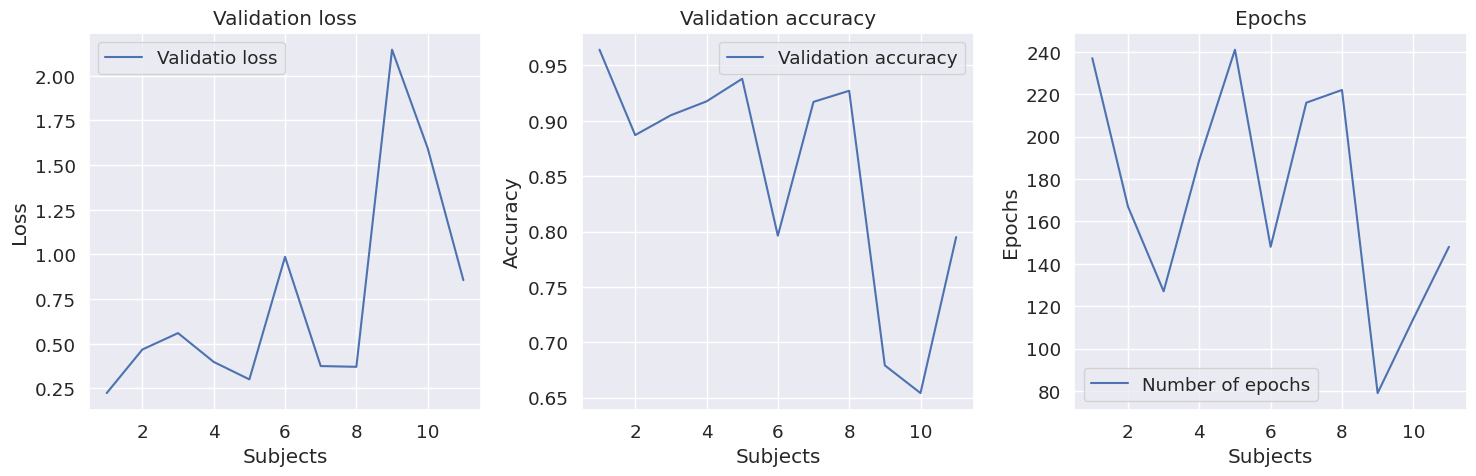


--------------------------------------------------
Average validation loss:  0.752494
Average validation accuracy:  0.852765
--------------------------------------------------


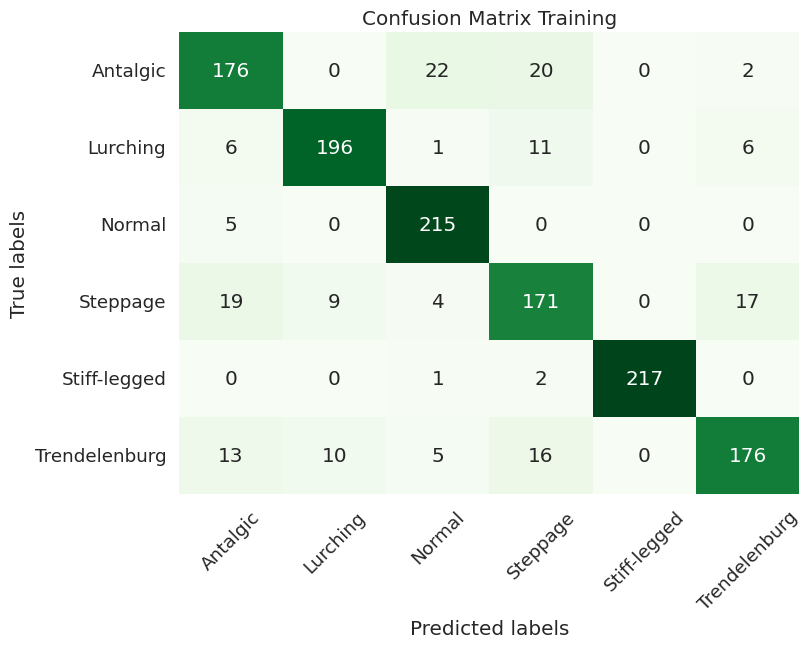

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.934091,0.800000,0.960909,0.803653
Lurching,0.967424,0.890909,0.982727,0.911628
Normal,0.971212,0.977273,0.970000,0.866935
Steppage,0.925758,0.777273,0.955455,0.777273
Stiff-legged,0.997727,0.986364,1.000000,1.000000
Trendelenburg,0.947727,0.800000,0.977273,0.875622


In [50]:
df_sk = cross_validation_results(cm=conf_matrix_sk, val_l=validation_loss_sk, val_a=validation_accuracy_sk, val_e=epochs_sk)
df_sk

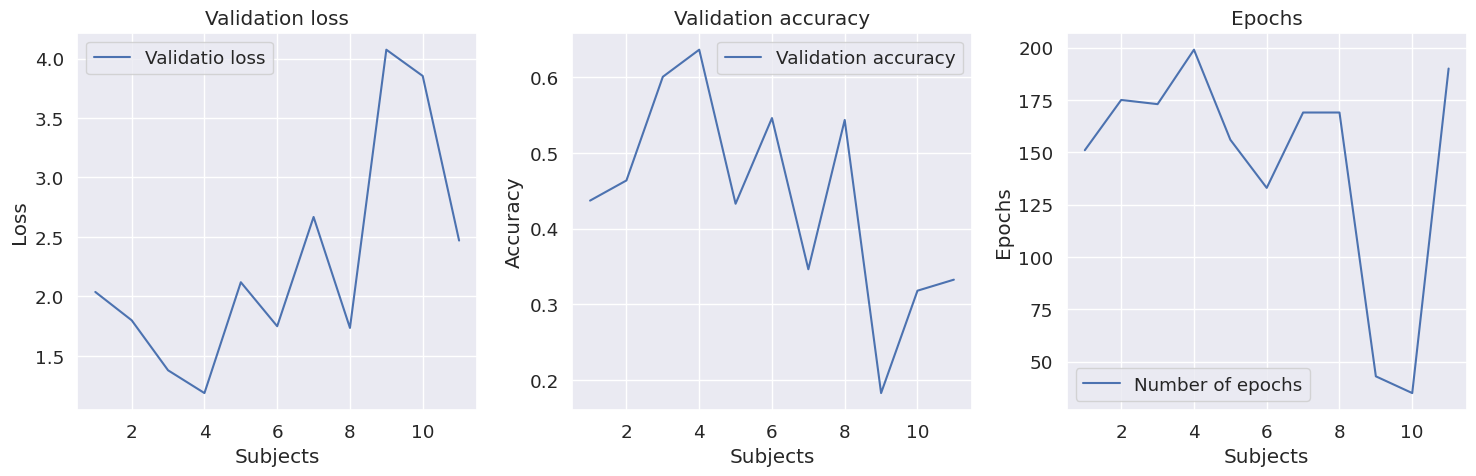


--------------------------------------------------
Average validation loss:  2.278841
Average validation accuracy:  0.440038
--------------------------------------------------


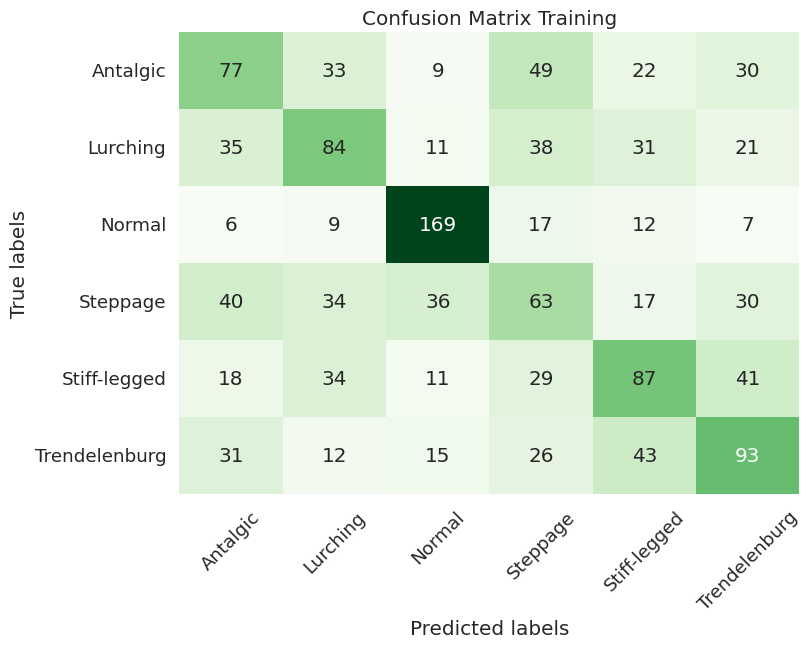

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.793182,0.350000,0.881818,0.371981
Lurching,0.804545,0.381818,0.889091,0.407767
Normal,0.899242,0.768182,0.925455,0.673307
Steppage,0.760606,0.286364,0.855455,0.283784
Stiff-legged,0.804545,0.395455,0.886364,0.410377
Trendelenburg,0.806061,0.422727,0.882727,0.418919


In [51]:
df_p = cross_validation_results(cm=conf_matrix_p, val_l=validation_loss_p, val_a=validation_accuracy_p, val_e=epochs_p)
df_p

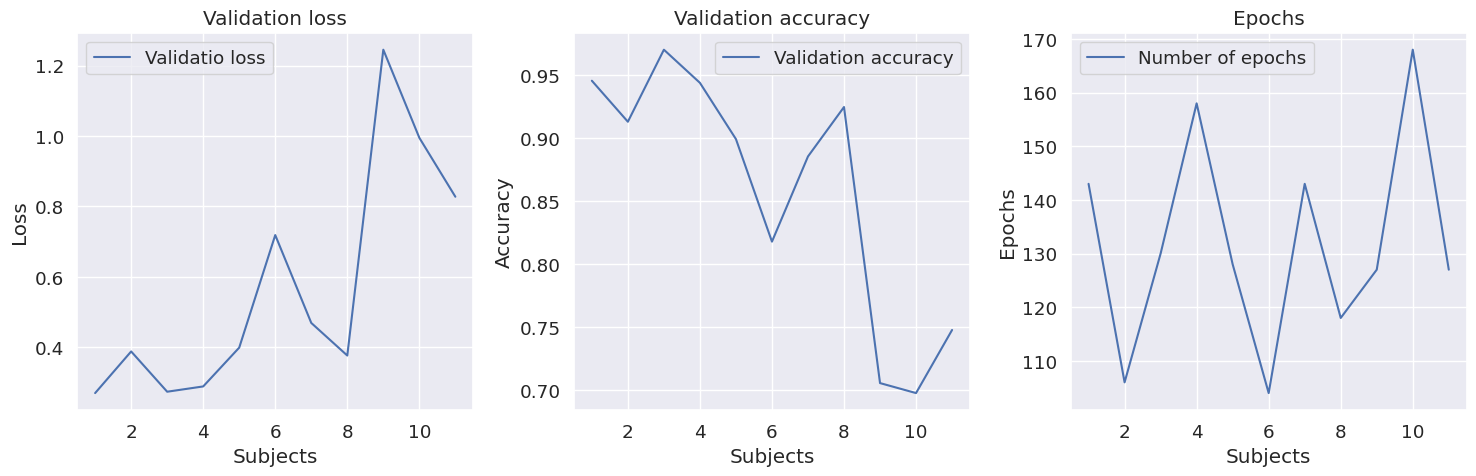


--------------------------------------------------
Average validation loss:  0.568707
Average validation accuracy:  0.859167
--------------------------------------------------


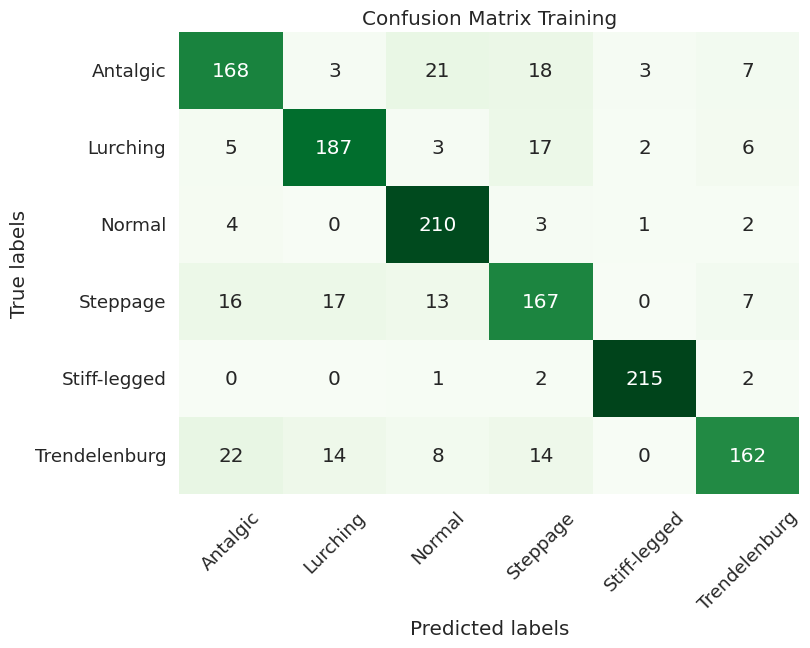

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.925000,0.763636,0.957273,0.781395
Lurching,0.949242,0.850000,0.969091,0.846154
Normal,0.957576,0.954545,0.958182,0.820312
Steppage,0.918939,0.759091,0.950909,0.755656
Stiff-legged,0.991667,0.977273,0.994545,0.972851
Trendelenburg,0.937879,0.736364,0.978182,0.870968


In [52]:
df_complete = cross_validation_results(cm=conf_matrix, val_l=validation_loss, val_a=validation_accuracy, val_e=epochs)
df_complete

In [53]:
print('Skeleton number of epochs:', int(np.mean(epochs_sk)))
print('Pressure number of epochs:', int(np.mean(epochs_p)))
print('Total architecture number of epochs:', int(np.mean(epochs)))

Skeleton number of epochs: 171
Pressure number of epochs: 144
Total architecture number of epochs: 132
